In [1]:
# !python3.8 -m pip install -U pip setuptools wheel scipy
# !python3.8 -m pip install -U 'fake_news_sis_simulator@git+https://github.com/HeavenVolkoff/simulador-sis-fakenews'

In [2]:
import numpy as np
import random
from math import ceil
from itertools import takewhile
import matplotlib.pyplot as plt
import fake_news_sis_simulator
from fake_news_sis_simulator import EventType, Simulator, q_matrix_k1, markov_timeline_probability_matrix, evolution_from_markov, edo_sis_k1

In [3]:
# Ajusta tamanho das imagens de plot
plt.rcParams["figure.figsize"] = (20,8)

### Função de Auxilio para Calculo da Margem de Seguranção

In [4]:
def align_simulation_time_window(window_size, max_time, simulation_time, simulation_data):
    """Alinha tempo baseado em windows de tempo, e garante que a saida vai ter exatamente a dimensão necessaria"""
    new_simulation_data = []
    last_index = 0
    for i in range(ceil(max_time/window_size)):
        mean_data = []
        while last_index < len(simulation_time) and simulation_time[last_index] <= (i+1)*window_size:
            mean_data.append(simulation_data[last_index])
            last_index += 1
        if len(mean_data) > 0:
            new_simulation_data.append(np.mean(mean_data))
        else:
            new_simulation_data.append(new_simulation_data[-1])
            
    return np.array(new_simulation_data)

### Parametros de simulação, Markov e EDO

In [5]:
LAMBDA_0 = 0.00
LAMBDA_1 = 0.00

In [6]:
POPULATION = 30
INITIAL_STATE = 1 # número de infectados

In [7]:
MU_0 = 0.15
MU_1 = 0.50
SIMULATION_TIME = 1

In [8]:
SAMPLES = 8
TRIALS = 8
WINDOW_COUNT = 100
WINDOW_SIZE = SIMULATION_TIME/WINDOW_COUNT

### Efetua Simulação

In [9]:
def simulation(simulator, simulation_time):
    time_list = [0]
    infected_list = [INITIAL_STATE]
    for time, _, stats in simulator:
        print(f"\rProgress {time*100/simulation_time}%", end="")
        time_list.append(time)
        infected_list.append(stats[EventType.Fake,])
        if time >= simulation_time:
            break
    return time_list, infected_list

def run_simulation():
    simulator = Simulator(
        (*([EventType.Fake] for _ in range(INITIAL_STATE)), *([EventType.Genuine] for _ in range(POPULATION - INITIAL_STATE))),
        fake_rate_heuristic=lambda _: 1,
        genuine_rate_heuristic=lambda _: 1,
        internal_fake_transmission_rate=MU_1,
        external_fake_transmission_rate=LAMBDA_1,
        internal_genuine_transmission_rate=MU_0,
        external_genuine_transmission_rate=LAMBDA_0,
    )
    simulacao_T, simulacao_I = simulation(simulator, SIMULATION_TIME)

    return simulacao_T, simulacao_I

In [10]:
simulacao_I_list = []


for idx in range(SAMPLES):
    print(f"Simulating {idx}/{SAMPLES}")
    trials = [run_simulation() for _ in range(TRIALS)]

    trials_t, trials_i = np.transpose(trials)
    trials_i = np.mean([np.array(align_simulation_time_window(WINDOW_SIZE, SIMULATION_TIME, trials_t[i], trials_i[i])) for i in range(trials_i.shape[0])], axis = 0)

    simulacao_I_list.append(trials_i)

Simulating 0/8
Progress 100.12029650190424%Simulating 1/8
Progress 9.722073160185264%%%

/home/raphael/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Progress 103.03962062712937%Simulating 2/8
Progress 100.13073617801074%Simulating 3/8
Progress 100.2905383172913%Simulating 4/8
Progress 100.00188565115316%%%Simulating 5/8
Progress 100.02105635572237%Simulating 6/8
Progress 101.25293918564071%Simulating 7/8
Progress 100.0101461707245%%%%

#### Calculo de intervalo de confiança

In [11]:
trials_t_simulacao = np.linspace(0, SIMULATION_TIME, WINDOW_COUNT)

infected_mean = np.mean(simulacao_I_list, 0)
infected_var = np.var(simulacao_I_list, 0)
ll_infectados = infected_mean - 1.96 * np.sqrt(infected_var) / np.sqrt(SAMPLES)
ul_infectados = infected_mean + 1.96 * np.sqrt(infected_var) / np.sqrt(SAMPLES)

health_mean = POPULATION - infected_mean
ll_health = POPULATION - ll_infectados
ul_health = POPULATION - ul_infectados

#### Preparando Plot da Simulação

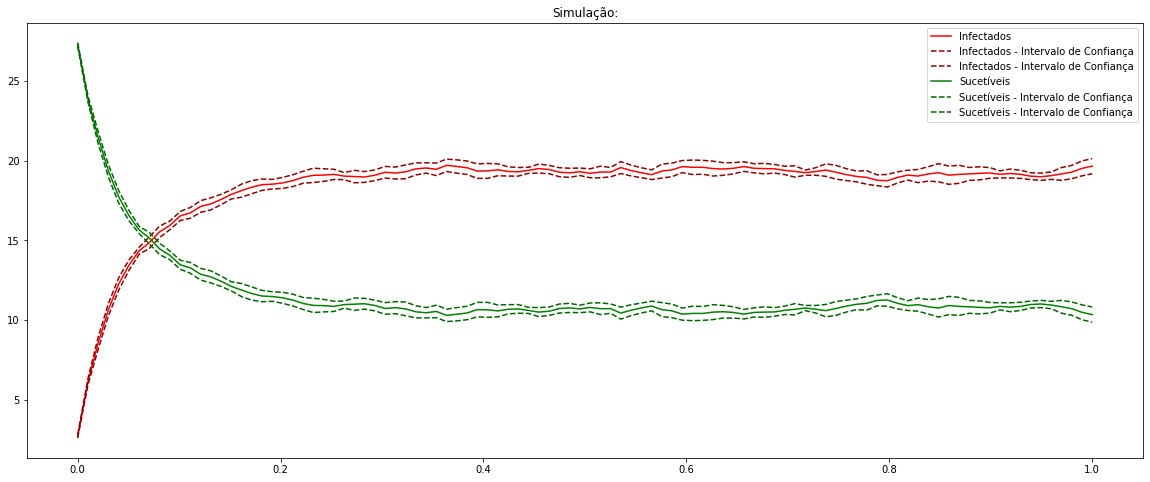

In [12]:
plt.title("Simulação:")
plt.plot(trials_t_simulacao, infected_mean, label="Infectados", color="red")
plt.plot(trials_t_simulacao, ll_infectados, label="Infectados - Intervalo de Confiança", color="darkred", linestyle="dashed")
plt.plot(trials_t_simulacao, ul_infectados, label="Infectados - Intervalo de Confiança", color="darkred", linestyle="dashed")

plt.plot(trials_t_simulacao, health_mean, label="Sucetíveis", color="green")
plt.plot(trials_t_simulacao, ll_health, label="Sucetíveis - Intervalo de Confiança", color="darkgreen", linestyle="dashed")
plt.plot(trials_t_simulacao, ul_health, label="Sucetíveis - Intervalo de Confiança", color="darkgreen", linestyle="dashed")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### Calcula Evolução da Cadeia de Markov

In [13]:
markov_q_matrix = q_matrix_k1(
    POPULATION,
    internal_fake_transmission_rate=MU_1,
    external_fake_transmission_rate=LAMBDA_1,
    internal_genuine_transmission_rate=MU_0,
    external_genuine_transmission_rate=LAMBDA_0,
)
trials_t_markov, markov_probability_timeline = markov_timeline_probability_matrix(
    markov_q_matrix,
    INITIAL_STATE,
    SIMULATION_TIME*100,
    100,
)

evolution = evolution_from_markov(markov_probability_timeline)

progress 100/100    

#### Prepara Plot da Evolução da Cadeia

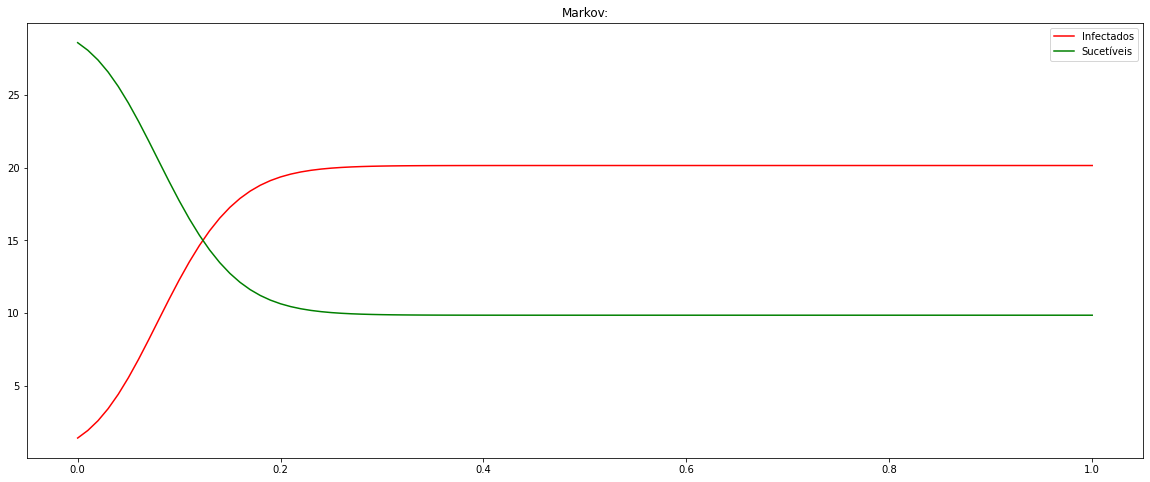

In [14]:
plt.title("Markov:")
plt.plot(np.linspace(0, SIMULATION_TIME, evolution.shape[0]), evolution, label="Infectados", color="red")

plt.plot(np.linspace(0, SIMULATION_TIME, evolution.shape[0]), POPULATION-evolution, label="Sucetíveis", color="green")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### Prepara Plot de Comparação Simulação X Markov

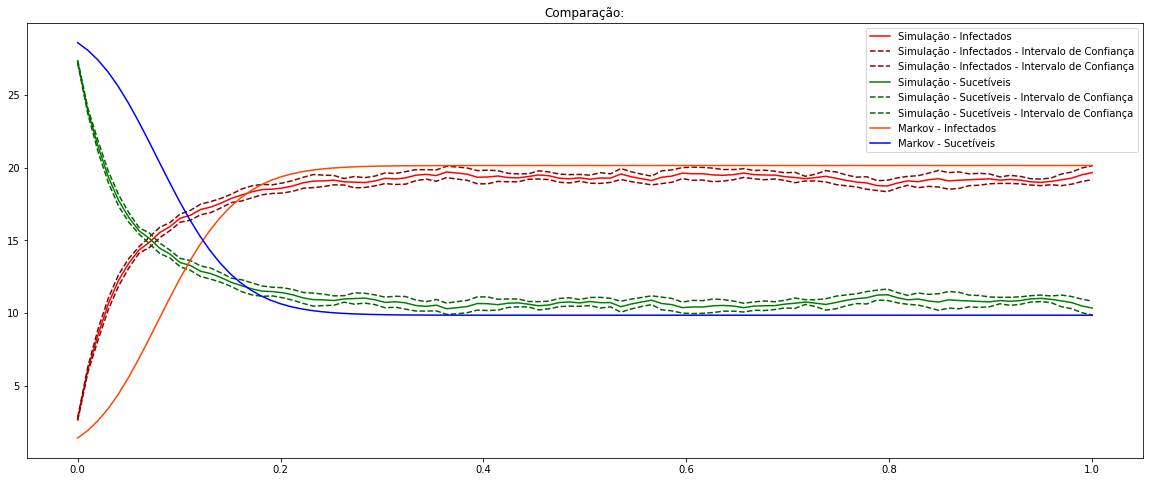

In [15]:
plt.title("Comparação:")
plt.plot(trials_t_simulacao, infected_mean, label="Simulação - Infectados", color="red")
plt.plot(trials_t_simulacao, ll_infectados, label="Simulação - Infectados - Intervalo de Confiança", color="darkred", linestyle="dashed")
plt.plot(trials_t_simulacao, ul_infectados, label="Simulação - Infectados - Intervalo de Confiança", color="darkred", linestyle="dashed")

plt.plot(trials_t_simulacao, health_mean, label="Simulação - Sucetíveis", color="green")
plt.plot(trials_t_simulacao, ll_health, label="Simulação - Sucetíveis - Intervalo de Confiança", color="darkgreen", linestyle="dashed")
plt.plot(trials_t_simulacao, ul_health, label="Simulação - Sucetíveis - Intervalo de Confiança", color="darkgreen", linestyle="dashed")

plt.plot(np.linspace(0, SIMULATION_TIME, evolution.shape[0]), evolution, label="Markov - Infectados", color="orangered")
plt.plot(np.linspace(0, SIMULATION_TIME, evolution.shape[0]), POPULATION-evolution, label="Markov - Sucetíveis", color="blue")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

### Calcula EDO para K=1

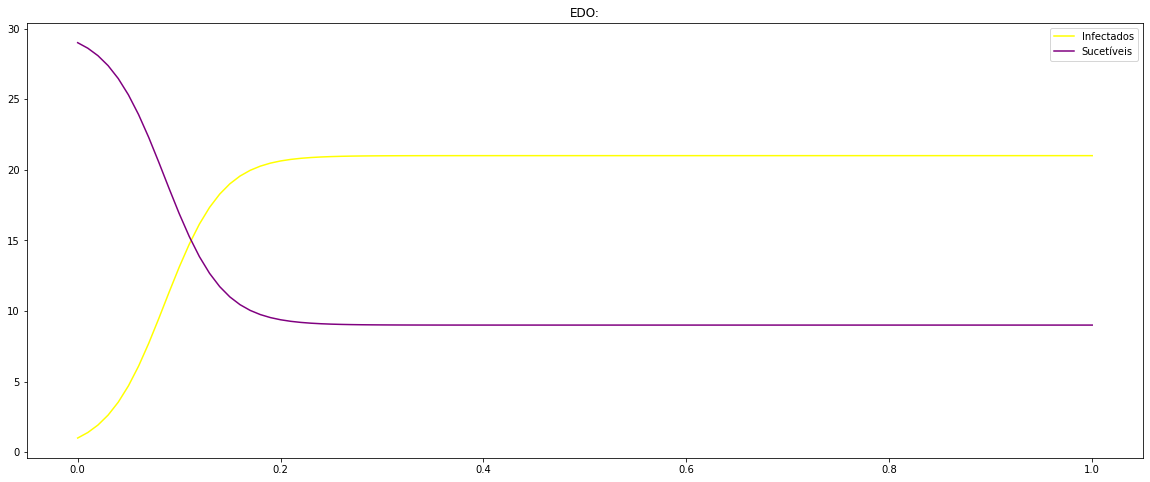

In [16]:
edo_results = edo_sis_k1(
    INITIAL_STATE/POPULATION,
    MU_1,
    MU_0,
    SIMULATION_TIME*100,
)

plt.title("EDO:")
plt.plot(np.linspace(0, SIMULATION_TIME, edo_results[:,1].shape[0]), edo_results[:,1]*POPULATION, label="Infectados", color="yellow")

plt.plot(np.linspace(0, SIMULATION_TIME, edo_results[:,1].shape[0]), POPULATION-edo_results[:,1]*POPULATION, label="Sucetíveis", color="purple")
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

#### Prepara Plot de Comparação Entre os 3 Métodos

19.659114583333334
20.151829908679954


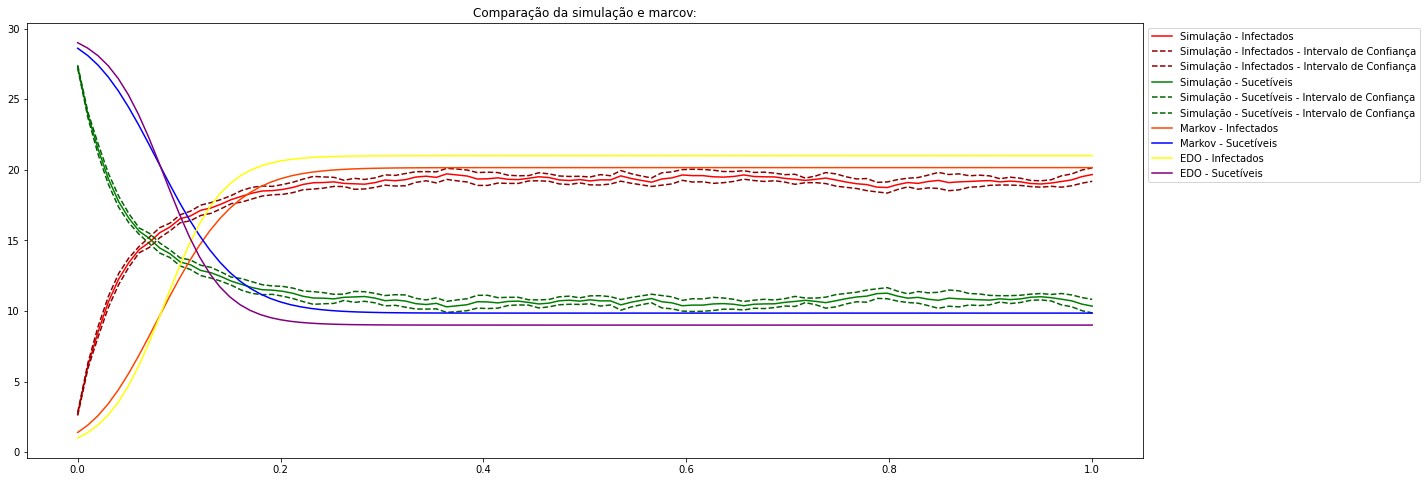

In [17]:
print(infected_mean[-1])
print(evolution[-1])

plt.title("Comparação da simulação e marcov:")
plt.plot(trials_t_simulacao, infected_mean, label="Simulação - Infectados", color="red")
plt.plot(trials_t_simulacao, ll_infectados, label="Simulação - Infectados - Intervalo de Confiança", color="darkred", linestyle="dashed")
plt.plot(trials_t_simulacao, ul_infectados, label="Simulação - Infectados - Intervalo de Confiança", color="darkred", linestyle="dashed")

plt.plot(trials_t_simulacao, health_mean, label="Simulação - Sucetíveis", color="green")
plt.plot(trials_t_simulacao, ll_health, label="Simulação - Sucetíveis - Intervalo de Confiança", color="darkgreen", linestyle="dashed")
plt.plot(trials_t_simulacao, ul_health, label="Simulação - Sucetíveis - Intervalo de Confiança", color="darkgreen", linestyle="dashed")

plt.plot(np.linspace(0, SIMULATION_TIME, evolution.shape[0]), evolution, label="Markov - Infectados", color="orangered")
plt.plot(np.linspace(0, SIMULATION_TIME, evolution.shape[0]), POPULATION-evolution, label="Markov - Sucetíveis", color="blue")

plt.plot(np.linspace(0, SIMULATION_TIME, edo_results[:,1].shape[0]), edo_results[:,1]*POPULATION, label="EDO - Infectados", color="yellow")
plt.plot(np.linspace(0, SIMULATION_TIME, edo_results[:,1].shape[0]), POPULATION-edo_results[:,1]*POPULATION, label="EDO - Sucetíveis", color="purple")

plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()